In [1]:
### Bu notebook verilerden her aydan 8 günde bir 1 gün alıyor.
### Veri localden okundu
### data_dir = "/home/han/data/smart-ds/2016/AUS/P1R/load_timeseries"
### ML model oluşturlmadı. Yanlızca keşfedici veri özellikleri kullanıldı !

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from tqdm import tqdm  # İlerleme çubuğu için

In [3]:
def load_and_process_data(file_path):
    """
    Load and process a load profile data file into a clean DataFrame.
    """
    # Extract day number from filename
    file_day = int(os.path.basename(file_path).split('_')[-1].split('.')[0])
    
    # Read the file content
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Find format line to get headers
    format_line = next((line for line in lines if line.startswith('FORMAT=')), None)
    if not format_line:
        raise ValueError("Could not find FORMAT= line in the file")
    
    # Extract headers
    headers = format_line.strip().split('=')[1].split(',')
    
    # Find the starting point for data (first line with 'res_')
    start_index = next((i for i, line in enumerate(lines) if 'res_' in line), 0)
    
    # Process the data
    data = []
    for line in lines[start_index:]:
        if not line.strip():
            continue
        
        parts = line.strip().split(',')
        if len(parts) < 12:  # Minimum required fields
            continue
        
        # Extract metadata
        customer_id = parts[0]
        profile_type = parts[1]
        
        # Extract load values (starting from the 11th column)
        values = [float(val) if val.strip() and val != 'None' else np.nan
                   for val in parts[11:] if val.strip()]
        
        # Create a row for each 15-minute interval
        for i, value in enumerate(values):
            # Calculate time information
            hour = (i * 15) // 60
            minute = (i * 15) % 60
            time_str = f"{hour:02d}:{minute:02d}"
            
            # Create data row
            data_row = {
                'customer_id': customer_id,
                'profile_type': profile_type,
                'day': file_day,
                'timestamp': time_str,
                'hour': hour,
                'minute': minute,
                'interval_idx': i,
                'load_percentage': value
            }
            data.append(data_row)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

In [4]:
def process_all_days(data_dir, sample_days=None):
    """
    Process all day files or a sample of days and combine them into one DataFrame.
    
    Args:
        data_dir: Directory containing the day files
        sample_days: If provided, only process these specific days (for testing)
    
    Returns:
        Combined DataFrame with all days' data
    """
    all_data = []
    
    # Get all day files
    if sample_days:
        day_files = [f"cyme_load_timeseries_day_{day}.txt" for day in sample_days]
    else:
        day_files = [f for f in os.listdir(data_dir) if f.startswith('cyme_load_timeseries_day_') and f.endswith('.txt')]
    
    print(f"Processing {len(day_files)} day files...")
    
    # Process each file
    for file_name in tqdm(day_files):
        file_path = os.path.join(data_dir, file_name)
        try:
            day_df = load_and_process_data(file_path)
            all_data.append(day_df)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
    
    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        raise ValueError("No data was successfully processed")

In [5]:
def add_date_info(df, year=2016):
    """
    Add date information to the DataFrame based on day number.
    2016 was a leap year, so we need to handle 366 days.
    """
    # Create a date for each day number
    start_date = datetime(year, 1, 1)
    
    # Add date column
    df['date'] = df['day'].apply(lambda day: start_date + timedelta(days=day-1))
    
    # Extract month and month name
    df['month'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.strftime('%B')
    
    return df

In [6]:
def calculate_monthly_averages(df):
    """
    Calculate monthly average load percentages.
    """
    # Group by month and calculate average load
    monthly_avg = df.groupby(['month', 'month_name'])['load_percentage'].mean().reset_index()
    
    # Sort by month number
    monthly_avg = monthly_avg.sort_values('month')
    
    return monthly_avg

In [7]:
def plot_monthly_averages(monthly_avg):
    """
    Create a bar chart of monthly average electricity consumption.
    """
    plt.figure(figsize=(12, 6))
    
    # Create bar chart
    sns.barplot(x='month_name', y='load_percentage', data=monthly_avg, palette='viridis')
    
    # Add labels and title
    plt.title('Aylık Ortalama Elektrik Tüketimi (2016)', fontsize=16)
    plt.xlabel('Ay', fontsize=12)
    plt.ylabel('Ortalama Yük Yüzdesi (%)', fontsize=12)
    plt.xticks(rotation=45)
    
    # Add value labels on top of bars
    for i, row in enumerate(monthly_avg.itertuples()):
        plt.text(i, row.load_percentage + 0.5, f'{row.load_percentage:.2f}%', 
                 ha='center', va='bottom', fontsize=10)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('monthly_average_consumption.png', dpi=300)
    
    return plt.gcf()

Processing 95 day files...


  0%|          | 0/95 [00:00<?, ?it/s]

100%|██████████| 95/95 [00:33<00:00,  2.81it/s]



Aylık Ortalama Elektrik Tüketimi:
January: 22.93%
February: 21.42%
March: 20.79%
April: 21.81%
May: 25.00%
June: 30.33%
July: 35.66%
August: 32.07%
September: 30.54%
October: 24.92%
November: 21.36%
December: 21.67%


/tmp/ipykernel_39777/1160720121.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month_name', y='load_percentage', data=monthly_avg, palette='viridis')



Aylık ortalama tüketim grafiği 'monthly_average_consumption.png' olarak kaydedildi.


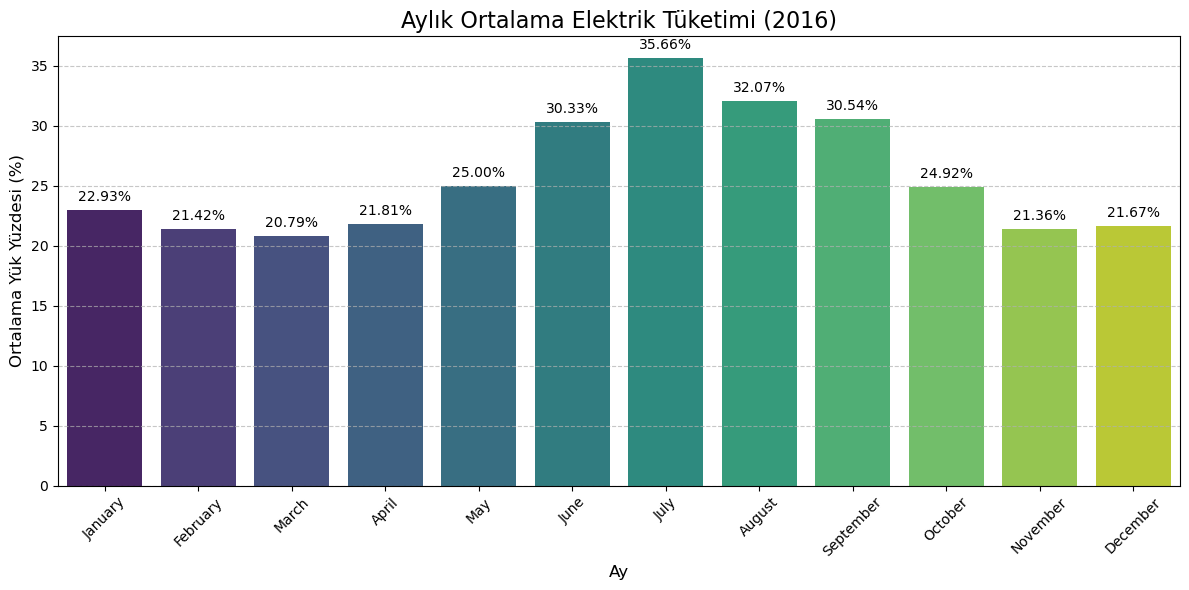

In [8]:
# Main execution
if __name__ == "__main__":
    # Data directory
    data_dir = "/home/han/data/smart-ds/2016/AUS/P1R/load_timeseries"
    
    # Option 1: Process all days (may take time)
    # combined_df = process_all_days(data_dir)
    
    # Option 2: Process a sample of days from each month for faster testing
    # Sample days from each month (about 3 days per month)
    sample_days = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]
    
    # For more accurate results, use more days
    # Get ~8 days from each month
    sample_days = []
    for month in range(1, 13):
        # Approximate day numbers for each month
        if month == 1:
            days = list(range(1, 32, 4))  # January
        elif month == 2:
            days = list(range(32, 60, 4))  # February
        elif month == 3:
            days = list(range(61, 91, 4))  # March
        elif month == 4:
            days = list(range(92, 121, 4))  # April
        elif month == 5:
            days = list(range(122, 152, 4))  # May
        elif month == 6:
            days = list(range(153, 182, 4))  # June
        elif month == 7:
            days = list(range(183, 213, 4))  # July
        elif month == 8:
            days = list(range(214, 244, 4))  # August
        elif month == 9:
            days = list(range(245, 274, 4))  # September
        elif month == 10:
            days = list(range(275, 305, 4))  # October
        elif month == 11:
            days = list(range(306, 335, 4))  # November
        else:  # month == 12
            days = list(range(336, 366, 4))  # December
        sample_days.extend(days)
    
    # Process the sample days
    combined_df = process_all_days(data_dir, sample_days)
    
    # Add date information
    combined_df = add_date_info(combined_df)
    
    # Calculate monthly averages
    monthly_avg = calculate_monthly_averages(combined_df)
    
    # Print the monthly averages
    print("\nAylık Ortalama Elektrik Tüketimi:")
    for _, row in monthly_avg.iterrows():
        print(f"{row['month_name']}: {row['load_percentage']:.2f}%")
    
    # Plot the monthly averages
    plot_monthly_averages(monthly_avg)
    print("\nAylık ortalama tüketim grafiği 'monthly_average_consumption.png' olarak kaydedildi.")
    
    plt.show()